# AI 201 Programming Assignment 3
## Multilayer Perceptron from Scratch

Submitted by: 
Jan Lendl R. Uy, 2019-00312

## Install and import necessary libraries
- numpy
- imbalanced-learn
- matplotlib
- tqdm
- ipywidgets

In [1]:
!pip install numpy matplotlib tqdm ipywidgets

In [2]:
import csv
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
## Notebook constants
NETWORK_A_WEIGHTS = "trained_weights_network_a.csv"
NETWORK_B_WEIGHTS = "trained_weights_network_b.csv"

NETWORK_A_PREDICTIONS = "predictions_for_test_tanh.csv"
NETWORK_B_PREDICTIONS = "predictions_for_test_leakyrelu.csv"

MLP_LEARNING_RATE = 1e-3
MLP_MOMENTUM = 0.92
MLP_HIDDEN_LAYER_SIZES = [64, 64]

## Load the dataset
- $X_{train}, X_{val}$: Dataset of features balanced via SMOTE in the other Jupyter notebook
- $y_{train}, y_{val}$: Dataset of labels balanced via SMOTE in the other Jupyter notebook

In [4]:
def load_dataset(features_file="features.csv", labels_file="labels.csv"):
    try:
        # Load features
        X = np.loadtxt(features_file, delimiter=',')
        
        # Load labels
        y = np.loadtxt(labels_file, delimiter=',', dtype=int)
        
        # Print info
        print(f"Dataset loaded successfully:")
        print(f"Features shape: {X.shape}")
        print(f"Labels shape: {y.shape}")
        
        return X, y
        
    except Exception as e:
        print(f"Error loading dataset: {str(e)}")
        return None, None


In [5]:
X_train, y_train = load_dataset("training_set.csv", "training_labels.csv")
X_val, y_val = load_dataset("validation_set.csv", "validation_labels.csv")

# print(f"Size of X_train: {X_train.shape}")
# print(f"Size of X_val: {X_val.shape}")
# print(f"Size of y_train: {y_train.shape}")
# print(f"Size of y_val: {y_val.shape}")

Dataset loaded successfully:
Features shape: (12200, 354)
Labels shape: (12200, 8)
Dataset loaded successfully:
Features shape: (800, 354)
Labels shape: (800, 8)


### Retrieve the test set to be used later for inference

In [6]:
def read_features_file(file_path, dtype=float):
    data = []
    try:
        with open(file_path, "r", newline="") as file:
            reader = csv.reader(file)
            # Read and convert data
            for row in reader:
                try:
                    converted_row = [dtype(val) for val in row]
                    data.append(converted_row)
                except ValueError as e:
                    raise ValueError(f"Error converting value in row: {row}. {str(e)}")
    except FileNotFoundError:
        raise FileNotFoundError(f"Could not find file: {file_path}")
    except Exception as e:
        raise Exception(f"Error reading CSV file {file_path}: {str(e)}")
    
    return np.array(data)

In [7]:
X_test = read_features_file("test_set.csv")

## Define the blocks of the Multilayer Perceptron

### Linear Layer
- Reminiscent to the `Linear` module of PyTorch
- Initializes the weights by sampling from a normal distribution
- Implements forward pass and backpropagation methods to be used by the MLP block

In [8]:
class Linear:
    
    def __init__(self, input_size, neurons, random_state=0):
        self.input = None
        self.output = None
        self.weight_gradients = None
        self.prev_weight_gradients = np.zeros((input_size + 1, neurons))
        
        np.random.seed(random_state)
        
        # Initialize weights with He initialization
        scale = np.sqrt(2.0 / input_size)  # Don"t include bias in scale calculation
        self.weights = np.random.normal(0, scale, (input_size + 1, neurons))
        
        # Initialize bias (last row) to zeros
        self.weights[-1, :] = 0.0
    
    def forward(self, X):
        bias = np.ones((X.shape[0], 1))
        self.input = np.hstack((X, bias))
        self.output = self.input @ self.weights
        return self.output
    
    def backward(self, delta):
        # Calculate gradients for all weights including bias
        self.weight_gradients = self.input.T @ delta
        return delta

### Activation Functions
- Contains the forward pass and backpropagation methods for the following activation functions:
    - Logistic/sigmoid function: $\sigma(x) = \frac{1}{1 + e^{-ax}}$
    - Hyperbolic tangent function: $\sigma(x) = a \tanh (bx)$
    - Leaky rectified linear unit (ReLU) function: $\sigma(x) = \max (ax, x)$

In [9]:
class Logistic():
    """Logistic/sigmoid activation function: sigma(x) = 1/(1 + exp(-ax))"""
    
    def __init__(self, a=1.0):
        self.a = a
        self.output = None
        self.input = None
        
    def forward(self, x):
        self.input = x
        self.output = 1 / (1 + np.exp(-self.a * self.input))
        return self.output
    
    def backward(self):
        # derivative = a * σ(ax)(1 - σ(ax))
        derivative = self.a * self.output * (1 - self.output)
        return derivative

class Tanh():
    """Hyperbolic tangent activation function: sigma(x) = a*tanh(bx)"""
    
    def __init__(self, a=1.0, b=1.0):
        self.a = a
        self.b = b
        self.output = None
        self.input = None
        
    def forward(self, x):
        """Forward pass of tanh function"""
        self.input = x
        self.output = self.a * np.tanh(self.b * x)
        return self.output
    
    def backward(self):
        """Backward pass of tanh function"""
        # derivative = a * b * (1 - tanh²(bx))
        derivative = self.b / self.a * (self.a - self.output) * (self.a + self.output)
        return derivative

class LeakyReLU():
    """Leaky ReLU activation function: sigma(x) = max(ax, x)"""
    
    def __init__(self, a=0.01):
        self.a = a
        self.output = None
        self.input = None
        
    def forward(self, x):
        """Forward pass of Leaky ReLU"""
        self.input = x
        self.output = np.where(x > 0, x, self.a * x)
        return self.output
    
    def backward(self):
        """Backward pass of Leaky ReLU"""
        derivative = np.where(self.input > 0, 1, self.a)
        return derivative

### Performance Evaluation Metrics
- Functions for computing the following classification metrics
    - Accuracy
    - Precision
    - Recall
    - F1-Score
    - Matthews Correlation Coefficient
- Plotting of the confusion matrix

In [10]:
def convert_to_labels(one_hot):
    """Helper function for converting one-hot encoded vectors back to integer class labels (1-8)"""
    return np.argmax(one_hot, axis=1) + 1

In [11]:
def accuracy_score(y_true, y_pred):
    """Compute accuracy score given ground truth y_true and predictions y_pred"""
    # Convert one-hot to class labels
    true_labels = convert_to_labels(y_true)
    pred_labels = convert_to_labels(y_pred)
    
    # Calculate accuracy
    return np.mean(true_labels == pred_labels)

def precision_recall_f1(y_true, y_pred):
    """Compute precision, recall, and F1-score given ground truth y_true and predictions y_pred"""
    # Convert to label format
    true_labels = convert_to_labels(y_true)
    pred_labels = convert_to_labels(y_pred)
    
    # Initialize dictionaries to store metrics for each class
    precision_dict = {}
    recall_dict = {}
    f1_dict = {}
    
    # Calculate metrics for each class
    unique_classes = np.unique(true_labels)
    
    for class_label in unique_classes:
        # True positives
        tp = np.sum((true_labels == class_label) & (pred_labels == class_label))
        
        # False positives
        fp = np.sum((true_labels != class_label) & (pred_labels == class_label))
        
        # False negatives
        fn = np.sum((true_labels == class_label) & (pred_labels != class_label))
        
        # Calculate precision
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        precision_dict[class_label] = precision
        
        # Calculate recall
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        recall_dict[class_label] = recall
        
        # Calculate F1 score
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_dict[class_label] = f1
    
    return precision_dict, recall_dict, f1_dict

def matthews_correlation_coefficient(y_true, y_pred):
    """Compute Matthew"s Correlation Coefficient given ground truth y_true and predictions y_pred"""
    # Convert to label format
    true_labels = convert_to_labels(y_true)
    pred_labels = convert_to_labels(y_pred)
    
    # Get number of classes
    n_classes = y_true.shape[1]
    
    # Create confusion matrix
    confusion_matrix = np.zeros((n_classes, n_classes))
    for i in range(len(true_labels)):
        confusion_matrix[true_labels[i]-1, pred_labels[i]-1] += 1
    
    # Calculate MCC
    t_sum = np.sum(confusion_matrix)
    s = np.sum(confusion_matrix.sum(axis=1) * confusion_matrix.sum(axis=0))
    ps = np.sum(np.diag(confusion_matrix))
    
    n = t_sum * t_sum
    
    # Calculate sum of squared predictions and true values
    sum_pred = np.sum(confusion_matrix.sum(axis=0) ** 2)
    sum_true = np.sum(confusion_matrix.sum(axis=1) ** 2)
    
    if n == sum_pred or n == sum_true:
        return 0.0
    
    mcc = (ps * n - s) / np.sqrt((n - sum_pred) * (n - sum_true))
    
    return mcc

def print_classification_metrics(y_true, y_pred):
    # Calculate all metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision_dict, recall_dict, f1_dict = precision_recall_f1(y_true, y_pred)
    mcc = matthews_correlation_coefficient(y_true, y_pred)
    
    # Print results
    print("\nClassification Metrics:")
    print("-" * 60)
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")
    print("\nPer-class metrics:")
    print("-" * 60)
    print(f"{'Class':<8} {'Precision':>10} {'Recall':>10} {'F1-Score':>10}")
    print("-" * 60)
    
    # Calculate macro averages
    macro_precision = 0
    macro_recall = 0
    macro_f1 = 0
    n_classes = 0
    
    for class_label in sorted(precision_dict.keys()):
        precision = precision_dict[class_label]
        recall = recall_dict[class_label]
        f1 = f1_dict[class_label]
        
        print(f"{class_label:<8} {precision:>10.4f} {recall:>10.4f} {f1:>10.4f}")
        
        macro_precision += precision
        macro_recall += recall
        macro_f1 += f1
        n_classes += 1
    
    # Print macro averages
    print("-" * 60)
    print(f"{'Macro':<8} {macro_precision/n_classes:>10.4f} "
          f"{macro_recall/n_classes:>10.4f} {macro_f1/n_classes:>10.4f}")
    print("-" * 60)

In [12]:
def confusion_matrix(y_true, y_pred):
    # Convert one-hot to class labels
    true_labels = convert_to_labels(y_true)
    pred_labels = convert_to_labels(y_pred)
    
    # Get number of classes
    n_classes = y_true.shape[1]
    
    # Create confusion matrix
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for t, p in zip(true_labels-1, pred_labels-1):
        cm[t, p] += 1
    
    return cm

def plot_confusion_matrix(y_true, y_pred, title=None):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create heatmap
    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    
    # Add colorbar
    plt.colorbar(im)
    
    # Get class labels
    n_classes = cm.shape[0]
    class_labels = [str(i) for i in range(1, n_classes + 1)]
    
    # Set tick marks and labels
    ax.set_xticks(np.arange(n_classes))
    ax.set_yticks(np.arange(n_classes))
    ax.set_xticklabels(class_labels)
    ax.set_yticklabels(class_labels)
    
    # Rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add labels and title
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    if title is None:
        title = "Confusion Matrix"
    plt.title(title)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "d"),
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black")
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, ax

In [13]:
def save_predictions(y_pred, filepath="predictions.csv"):
    """Save model predictions as integers to a CSV file."""
    # Ensure filepath has .csv extension
    if not filepath.endswith(".csv"):
        filepath = filepath + ".csv"
        
    try:
        # Convert one-hot encoded predictions to class labels (1-8)
        class_predictions = np.argmax(y_pred, axis=1) + 1
        
        # Save predictions
        np.savetxt(filepath, class_predictions, fmt="%d")
        
        print(f"Predictions saved to {filepath}")
        print(f"Total samples: {len(class_predictions)}")
        
    except Exception as e:
        print(f"Error saving predictions: {str(e)}")

### Multilayer Perceptron implementation
- Encompasses the following methods for the implementation of the MLP from scratch
    - Initialization of architectural parameters
        - Layer sizes
        - Batch size
        - Activation functions for each layer
    - Optimization hyperparameters
        - Learning rate
        - Momentum
    - Forward pass through a 2-layer MLP
    - Backpropagation through a 2-layer MLP
    - Training for a specified number of epochs

In [14]:
class MLP:
    
    def __init__(self, 
                 input_size,
                 output_size,
                 learning_rate=1e-4,
                 momentum=0.9,
                 hidden_sizes=[64, 64],
                 batch_size=8,
                 activations=[LeakyReLU(), LeakyReLU(), Logistic()]
        ):
        self.input_size = input_size
        self.output_size = output_size
        self.activations = activations
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.momentum = momentum
        
        self.linear_block_1 = Linear(input_size, hidden_sizes[0])
        self.linear_block_2 = Linear(hidden_sizes[0], hidden_sizes[1])
        self.linear_block_3 = Linear(hidden_sizes[1], output_size)
        self.activation_block_1 = activations[0]
        self.activation_block_2 = activations[1]
        self.activation_block_3 = activations[2]
        
        self.training_losses = None
        self.validation_losses = None

    def forward(self, X):
        v_1 = self.linear_block_1.forward(X)
        y_1 = self.activation_block_1.forward(v_1)
        v_2 = self.linear_block_2.forward(y_1)
        y_2 = self.activation_block_2.forward(v_2)  
        v_out = self.linear_block_3.forward(y_2)
        y_out = self.activation_block_3.forward(v_out)
        return y_out
    
    def sum_squared_errors(self, error):
        return 1/2 * np.sum(error**2)
    
    def backpropagate(self, error):
        # Output layer
        delta_out = error * self.activation_block_3.backward()
        delta_out = self.linear_block_3.backward(delta_out)
        
        # Second hidden layer - use non-bias weights for backward pass
        delta_hidden_2 = (delta_out @ self.linear_block_3.weights[:-1, :].T) * \
                        self.activation_block_2.backward()
        delta_hidden_2 = self.linear_block_2.backward(delta_hidden_2)
        
        # First hidden layer - use non-bias weights for backward pass
        delta_hidden_1 = (delta_hidden_2 @ self.linear_block_2.weights[:-1, :].T) * \
                        self.activation_block_1.backward()
        self.linear_block_1.backward(delta_hidden_1)
        
        # self._update_parameters()
        
    def _update_parameters(self):
        # Update weights and biases for all layers
        layers = [self.linear_block_1, self.linear_block_2, self.linear_block_3]
        
        for layer in layers:
            # Update weights
            weight_update = (self.learning_rate * layer.weight_gradients + 
                           self.momentum * layer.prev_weight_gradients)
            layer.weights += weight_update
            layer.prev_weight_gradients = weight_update
            
    def _get_learning_curves(self):
        if self.training_losses is not None and self.validation_losses is not None:
            # Create epochs array
            epochs = np.arange(0, len(self.training_losses)) * 5  # Multiply by 5 since we save every 5th epoch
            
            # Create a figure with two subplots side by side
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            
            # Plot training loss
            ax1.plot(epochs, self.training_losses, color="#2ecc71", linewidth=2)  # Green color
            ax1.set_title("Training Loss", fontsize=14, pad=15)
            ax1.set_xlabel("Epoch", fontsize=12)
            ax1.set_ylabel("Sum of Squared Errors Loss", fontsize=12)
            ax1.grid(True, linestyle="--", alpha=0.7)
            ax1.minorticks_on()
            ax1.grid(True, which="minor", linestyle=":", alpha=0.4)
            
            # Plot validation loss
            ax2.plot(epochs, self.validation_losses, color="#e74c3c", linewidth=2)  # Red color
            ax2.set_title("Validation Loss", fontsize=14, pad=15)
            ax2.set_xlabel("Epoch", fontsize=12)
            ax2.set_ylabel("Sum of Squared Errors Loss", fontsize=12)
            ax2.grid(True, linestyle="--", alpha=0.7)
            ax2.minorticks_on()
            ax2.grid(True, which="minor", linestyle=":", alpha=0.4)
            
            # Adjust layout to prevent overlap
            plt.tight_layout()
            
            # Show plot
            plt.show()

    def train(self, X_train, y_train, X_val=None, y_val=None, n_epochs=500, suppress_plot=False):
        # Create mini-batches
        n_samples = X_train.shape[0]
        n_batches = n_samples // self.batch_size
        
        # epoch_iterator = tqdm(range(n_epochs), desc="Training the multilayer perceptron")
        self.training_losses = []
        self.validation_losses = []

        # for epoch in epoch_iterator:
        for epoch in range(n_epochs):
            # Shuffle training data
            indices = np.random.permutation(n_samples)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train[indices]
            
            epoch_loss = 0
            for batch in range(n_batches):
                start_idx = batch * self.batch_size
                end_idx = start_idx + self.batch_size
                
                X_batch = X_train_shuffled[start_idx:end_idx]
                y_batch = y_train_shuffled[start_idx:end_idx]
                
                # Forward pass on training batch
                y_pred = self.forward(X_batch)
                
                # Compute training error and loss
                error_train = y_batch - y_pred
                loss_train = self.sum_squared_errors(error_train)
                epoch_loss += loss_train
                
                # Backpropagation
                self.backpropagate(error_train)
                
                # Update parameters
                self._update_parameters()
            
            # Forward pass on entire validation set
            y_pred_val = self.forward(X_val)
            
            # Compute validation error and loss
            error_val = y_val - y_pred_val
            loss_val = self.sum_squared_errors(error_val)
            
            # Update progress bar
            # epoch_iterator.set_postfix({
            #     "Training Loss": f"{epoch_loss:.6f}",
            #     "Validation Loss": f"{loss_val:.6f}"
            # })
        
            # Save losses every 5 epochs
            if epoch % 5 == 0:
                self.training_losses.append(epoch_loss)
                self.validation_losses.append(loss_val)

        if not suppress_plot:
            # Plot learning curves after training
            self._get_learning_curves()

### Helper functions for saving and loading of trained model
Inspired by the idea of saving and loading of model architecture and its parameters in PyTorch. Model architecture is saved as a state dictionary that is included in the .csv file that stores model state. Similarly, loading the model involves validating the architectural configuration of the model from the state dictionary then setting the weights of the loaded model with the parameters saved in the .csv file.

In [15]:
def state_dict(model):
    """Returns a dictionary containing a whole state of the module."""
    return {
        # Model weights
        "linear1.weight": model.linear_block_1.weights.copy(),
        "linear2.weight": model.linear_block_2.weights.copy(),
        "linear3.weight": model.linear_block_3.weights.copy(),
        
        # Model architecture
        "architecture": {
            "input_size": model.input_size,
            "hidden_sizes": [
                model.linear_block_1.weights.shape[1],
                model.linear_block_2.weights.shape[1]
            ],
            "output_size": model.output_size
        },
        
        # Hyperparameters
        "hyperparameters": {
            "learning_rate": model.learning_rate,
            "momentum": model.momentum
        }
    }

def load_state_dict(model, state_dict):
    """Loads a model state dictionary."""
    try:
        # Verify architecture matches
        saved_arch = state_dict["architecture"]
        if (saved_arch["input_size"] != model.input_size or
            saved_arch["output_size"] != model.output_size or
            saved_arch["hidden_sizes"][0] != model.linear_block_1.weights.shape[1] or
            saved_arch["hidden_sizes"][1] != model.linear_block_2.weights.shape[1]):
            raise ValueError(
                f"Architecture mismatch:\n"
                f"Saved model: in={saved_arch['input_size']}, "
                f"hidden={saved_arch['hidden_sizes']}, "
                f"out={saved_arch['output_size']}\n"
                f"Current model: in={model.input_size}, "
                f"hidden=[{model.linear_block_1.weights.shape[1]}, "
                f"{model.linear_block_2.weights.shape[1]}], "
                f"out={model.output_size}"
            )
        
        # Load weights
        model.linear_block_1.weights = state_dict["linear1.weight"]
        model.linear_block_2.weights = state_dict["linear2.weight"]
        model.linear_block_3.weights = state_dict["linear3.weight"]
        
        # Reset momentum gradients
        model.linear_block_1.prev_weight_gradients = np.zeros_like(model.linear_block_1.weights)
        model.linear_block_2.prev_weight_gradients = np.zeros_like(model.linear_block_2.weights)
        model.linear_block_3.prev_weight_gradients = np.zeros_like(model.linear_block_3.weights)
        
        # Optionally load hyperparameters
        model.learning_rate = state_dict["hyperparameters"]["learning_rate"]
        model.momentum = state_dict["hyperparameters"]["momentum"]
        
        print("Successfully loaded model state")
        return True
        
    except Exception as e:
        print(f"Error loading state dictionary: {str(e)}")
        return False

def save_model(model, filepath):
    """Save model state to CSV file."""
    if not filepath.endswith(".csv"):
        filepath = filepath + ".csv"
    
    try:
        state = state_dict(model)
        
        # Write to CSV
        with open(filepath, "w") as f:
            # Write architecture and hyperparameters
            f.write(f"# Architecture: {state['architecture']['input_size']},"
                f"{state['architecture']['hidden_sizes'][0]},"
                f"{state['architecture']['hidden_sizes'][1]},"
                f"{state['architecture']['output_size']}\n")
            f.write(f"# Learning Rate: {state['hyperparameters']['learning_rate']}\n")
            f.write(f"# Momentum: {state['hyperparameters']['momentum']}\n")
            f.write("# Layer weights below: layer1, layer2, layer3\n")
            
            # Write weights for each layer
            np.savetxt(f, state["linear1.weight"], delimiter=",")
            f.write("# Layer 2\n")
            np.savetxt(f, state["linear2.weight"], delimiter=",")
            f.write("# Layer 3\n")
            np.savetxt(f, state["linear3.weight"], delimiter=",")
            
        print(f"Model saved to {filepath}")
        
    except Exception as e:
        print(f"Error saving model: {str(e)}")

def load_model(model, filepath):
    """Load model state from CSV file."""
    if not filepath.endswith(".csv"):
        filepath = filepath + ".csv"
    
    try:
        # Read the full file
        with open(filepath, "r") as f:
            lines = f.readlines()
        
        # Parse architecture and hyperparameters
        arch_line = lines[0].strip("# Architecture: \n").split(",")
        input_size, hidden_size_1, hidden_size_2, output_size = map(int, arch_line)
        lr_line = float(lines[1].strip("# Learning Rate: \n"))
        momentum_line = float(lines[2].strip("# Momentum: \n"))
                    
        # Find layer start indices
        layer_starts = []
        for i, line in enumerate(lines):
            if line.startswith("# Layer"):
                layer_starts.append(i + 1)
                            
        # Parse weights
        layer1_data = [list(map(float, line.strip().split(","))) 
                    for line in lines[layer_starts[0]:layer_starts[1]] if line.strip() and not line.startswith("#")]
        layer2_data = [list(map(float, line.strip().split(","))) 
                    for line in lines[layer_starts[1]:layer_starts[2]] if line.strip() and not line.startswith("#")]
        layer3_data = [list(map(float, line.strip().split(","))) 
                    for line in lines[layer_starts[2]:] if line.strip() and not line.startswith("#")]
        
        # Create state dict
        state = {
            "architecture": {
                "input_size": input_size,
                "hidden_sizes": [hidden_size_1, hidden_size_2],
                "output_size": output_size
            },
            "hyperparameters": {
                "learning_rate": lr_line,
                "momentum": momentum_line
            },
            "linear1.weight": np.array(layer1_data),
            "linear2.weight": np.array(layer2_data),
            "linear3.weight": np.array(layer3_data)
        }
        
        # Load the state
        success = load_state_dict(model, state)
        if success:
            print(f"Model loaded from {filepath}")
            
    except Exception as e:
        print(f"Error loading model: {str(e)}")

### Grid search
- Function to search for the best set of hyperparameters of the 2-Layer MLP
- Tunable parameters:
    - Learning rate
    - Momentum
    - Hidden layer sizes
- Batch size is not included to reduce search time

In [16]:
def grid_search_mlp(X_train, y_train, X_val, y_val, param_grid, n_epochs=500):
    """Perform grid search for MLP hyperparameter optimization using nested loops."""
    # Initialize tracking variables
    best_score = -np.inf
    best_params = None
    all_results = []
    
    # Calculate total combinations for progress tracking
    total_combinations = 1
    for values in param_grid.values():
        total_combinations *= len(values)
    print(f"Total parameter combinations to try: {total_combinations}")
    
    # Counter for current combination
    combinations = 0
    
    # Nested loops for each parameter
    for lr in param_grid['learning_rate']:
        for mom in param_grid['momentum']:
            for hidden in param_grid['hidden_sizes']:
                combinations += 1
                print(f"\nTrying combination {combinations}/{total_combinations}")
                
                # Current parameter combination
                current_params = {
                    "learning_rate": lr,
                    "momentum": mom,
                    "hidden_sizes": hidden
                }
                print("Current parameters:", current_params)
                
                # Create and train model
                model = MLP(
                    input_size=X_train.shape[1],
                    output_size=y_train.shape[1],
                    learning_rate=lr,
                    momentum=mom,
                    hidden_sizes=hidden,
                    activations=[Tanh(a=1.716, b=2/3), 
                                Tanh(a=1.716, b=2/3), 
                                Logistic(a=2.0)]
                )
                
                # Train the model
                model.train(X_train, y_train, X_val, y_val, n_epochs=n_epochs, suppress_plot=True)
                
                # Get predictions
                val_pred = model.forward(X_val)
                
                # Calculate accuracy
                accuracy = accuracy_score(y_val, val_pred)
                print(f"Validation accuracy: {accuracy:.5f}")
                
                # Store results
                result = {
                    'params': current_params.copy(),
                    'accuracy': accuracy
                }
                all_results.append(result)
                
                # Update best parameters if current model is better
                if accuracy > best_score:
                    best_score = accuracy
                    best_params = current_params.copy()
                    print("New best model found!")
    
    print("\nGrid search completed!")
    print(f"Best parameters: {best_params}")
    print(f"Best validation accuracy: {best_score:.5f}")
    
    return best_params, best_score, all_results

### Find the best set of hyperparameters of Network A using grid search

In [29]:
# Parameter grid to be used for search
param_grid = {
    "learning_rate": [1e-4, 1e-3, 5e-3],
    "momentum": [0.85, 0.9, 0.95],
    "hidden_sizes": [[32, 32], [64, 64]],
}

# Perform grid search
best_params, best_score, all_results = grid_search_mlp(
    X_train, y_train, X_val, y_val, param_grid, n_epochs=500
)

Total parameter combinations to try: 18

Trying combination 1/18
Current parameters: {'learning_rate': 0.0001, 'momentum': 0.85, 'hidden_sizes': [32, 32]}
Validation accuracy: 0.99000
New best model found!

Trying combination 2/18
Current parameters: {'learning_rate': 0.0001, 'momentum': 0.85, 'hidden_sizes': [64, 64]}
Validation accuracy: 0.99375
New best model found!

Trying combination 3/18
Current parameters: {'learning_rate': 0.0001, 'momentum': 0.9, 'hidden_sizes': [32, 32]}
Validation accuracy: 0.99000

Trying combination 4/18
Current parameters: {'learning_rate': 0.0001, 'momentum': 0.9, 'hidden_sizes': [64, 64]}
Validation accuracy: 0.99375

Trying combination 5/18
Current parameters: {'learning_rate': 0.0001, 'momentum': 0.95, 'hidden_sizes': [32, 32]}
Validation accuracy: 0.99250

Trying combination 6/18
Current parameters: {'learning_rate': 0.0001, 'momentum': 0.95, 'hidden_sizes': [64, 64]}
Validation accuracy: 0.99250

Trying combination 7/18
Current parameters: {'learnin

## Network A
- Hidden Layer 1
    - Activation Function: `Tanh(a=1.716, b=2/3)`
- Hidden Layer 2
    - Activation Function: `Tanh(a=1.716, b=2/3)`
- Output Layer
    - Activation Function: `Logistic(a=2.0)`

### Assess the performance of Network A using the best hyperparameters found in grid search

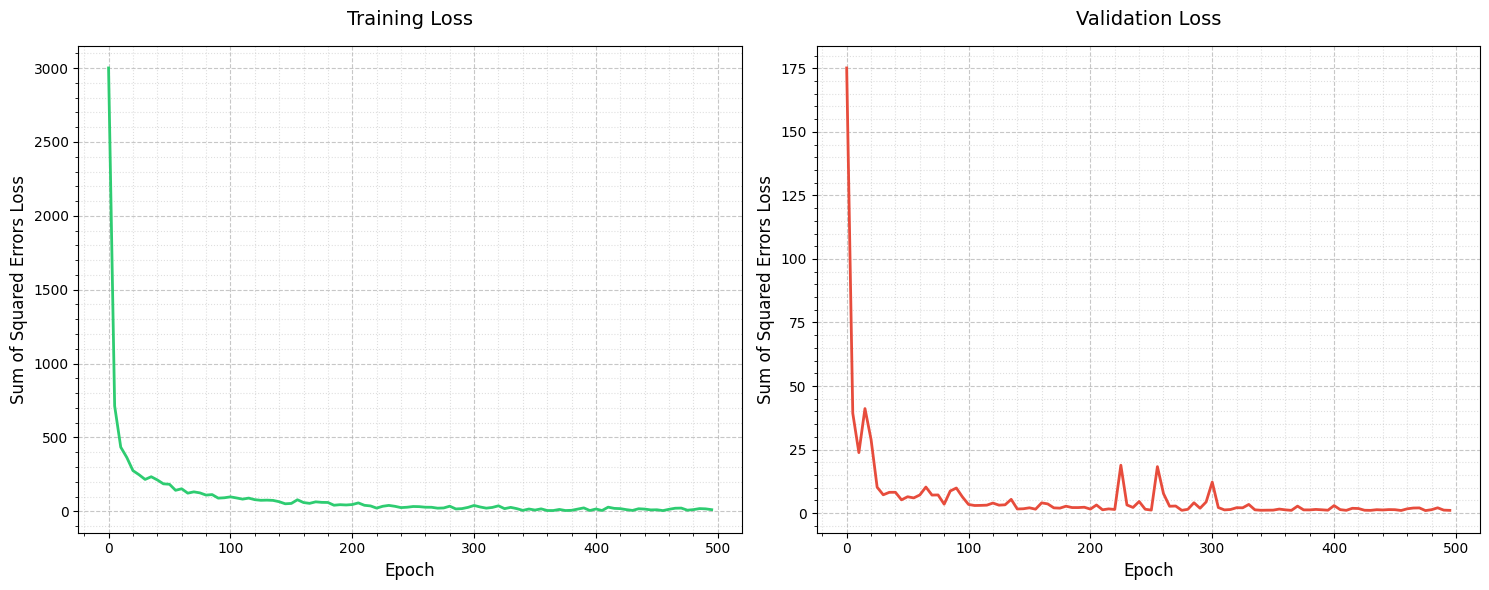

Training time of Network A: 76.39800190925598 s
Model saved to trained_weights_network_a.csv


In [30]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]
network_a_activations=[Tanh(a=1.716, b=2/3), 
             Tanh(a=1.716, b=2/3), 
             Logistic(a=2.0)]

network_a = MLP(
                learning_rate=best_params["learning_rate"],
                momentum=best_params["momentum"],
                input_size=input_size,
                output_size=output_size,
                hidden_sizes=best_params["hidden_sizes"],
                activations=network_a_activations
            )

# Train Network A and get the training time
start_time = time.time()
network_a.train(X_train, y_train, X_val, y_val, n_epochs=500)
print(f"Training time of Network A: {time.time() - start_time} s")

# Save the trained weights of Network A
save_model(network_a, NETWORK_A_WEIGHTS)

### Reconstruct Network A by loading its trained weights

In [31]:
loaded_network_a = MLP(
                learning_rate=best_params["learning_rate"],
                momentum=best_params["momentum"],
                input_size=input_size,
                output_size=output_size,
                hidden_sizes=best_params["hidden_sizes"],
                activations=network_a_activations
            )
load_model(loaded_network_a, NETWORK_A_WEIGHTS)

# Sanity Check: Confirm that the loaded network is correct
print(network_a.forward(X_val) == loaded_network_a.forward(X_val))

# Perform inference on the validation set for metrics
y_val_pred_network_a = loaded_network_a.forward(X_val)

Successfully loaded model state
Model loaded from trained_weights_network_a.csv
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


### Classification metrics of Network A

In [32]:
print_classification_metrics(y_val, y_val_pred_network_a)


Classification Metrics:
------------------------------------------------------------
Overall Accuracy: 1.0000
Matthews Correlation Coefficient: 914.8805

Per-class metrics:
------------------------------------------------------------
Class     Precision     Recall   F1-Score
------------------------------------------------------------
1            1.0000     1.0000     1.0000
2            1.0000     1.0000     1.0000
3            1.0000     1.0000     1.0000
4            1.0000     1.0000     1.0000
5            1.0000     1.0000     1.0000
6            1.0000     1.0000     1.0000
7            1.0000     1.0000     1.0000
8            1.0000     1.0000     1.0000
------------------------------------------------------------
Macro        1.0000     1.0000     1.0000
------------------------------------------------------------


(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Label', ylabel='True Label'>)

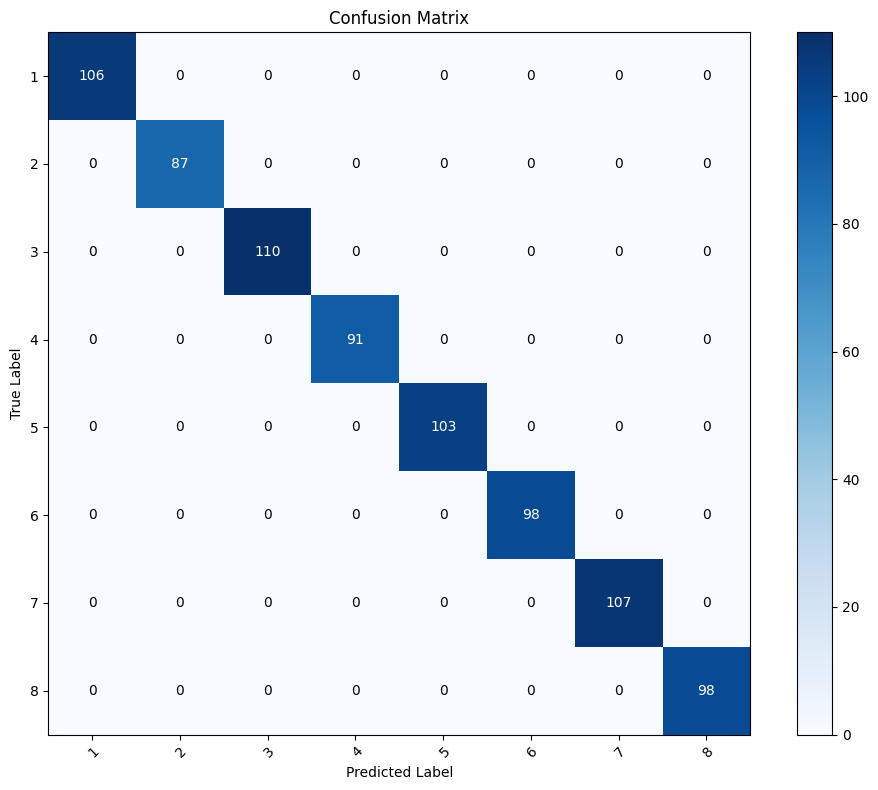

In [33]:
plot_confusion_matrix(y_val, y_val_pred_network_a)

### Perform inference on the test set and save predictions

In [34]:
y_test_pred_network_a = loaded_network_a.forward(X_test)
save_predictions(y_test_pred_network_a, NETWORK_A_PREDICTIONS)

Predictions saved to predictions_for_test_tanh.csv
Total samples: 701


## Network B
- Hidden Layer 1
    - Activation Function: `LeakyReLU(a=0.01)`
- Hidden Layer 2
    - Activation Function: `LeakyReLU(a=0.01)`
- Output Layer
    - Activation Function: `Logistic(a=2.0)`

### Assess the performance of Network B with the same hyperparameters as Network A

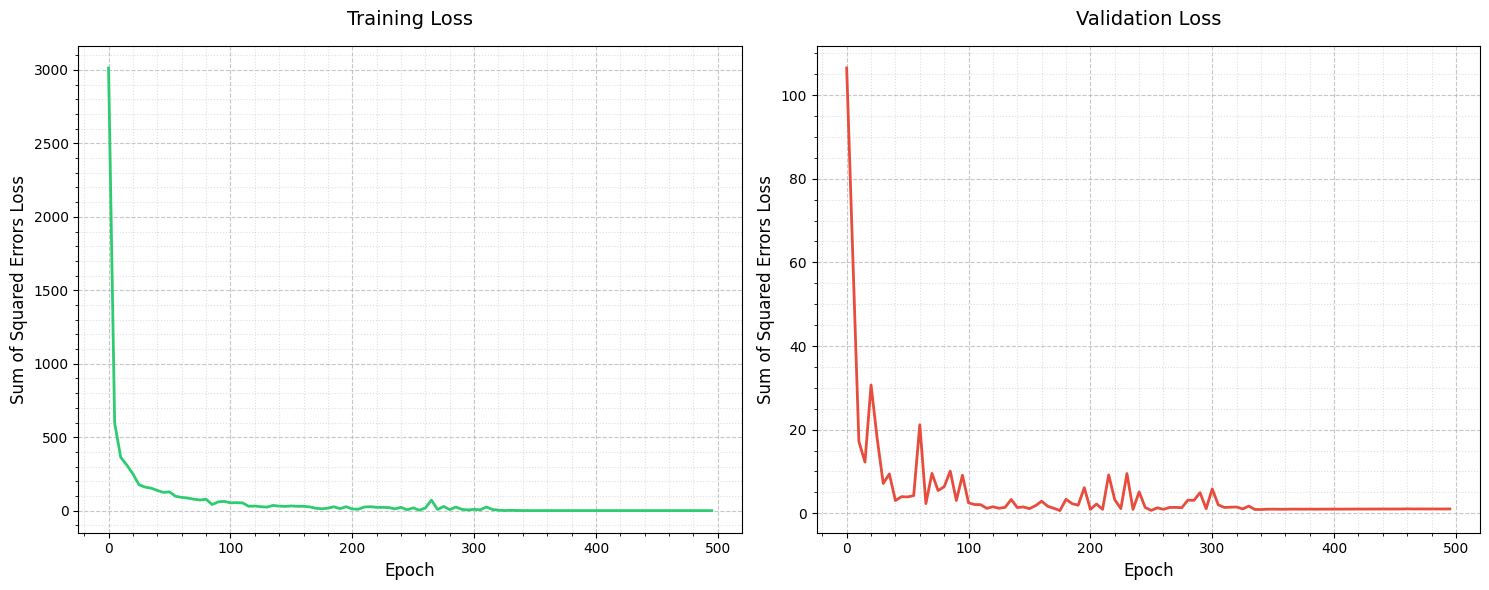

Training time of Network B: 73.36064505577087 s
Model saved to trained_weights_network_b.csv


In [35]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]
network_b_activations=[LeakyReLU(a=0.01), 
                       LeakyReLU(a=0.01), 
                       Logistic(a=2.0)]

network_b = MLP(
                learning_rate=best_params["learning_rate"],
                momentum=best_params["momentum"],
                input_size=input_size,
                output_size=output_size,
                hidden_sizes=best_params["hidden_sizes"],
                activations=network_b_activations
            )

# Train Network B and get the training time
start_time = time.time()
network_b.train(X_train, y_train, X_val, y_val, n_epochs=500)
print(f"Training time of Network B: {time.time() - start_time} s")

# Save the trained weights of Network B
save_model(network_b, NETWORK_B_WEIGHTS)

### Reconstruct Network B by loading its trained weights

In [36]:
loaded_network_b = MLP(
                learning_rate=best_params["learning_rate"],
                momentum=best_params["momentum"],
                input_size=input_size,
                output_size=output_size,
                hidden_sizes=best_params["hidden_sizes"],
                activations=network_b_activations
            )
load_model(loaded_network_b, NETWORK_B_WEIGHTS)

# Sanity Check: Confirm that the loaded network is correct
print(network_b.forward(X_val) == loaded_network_b.forward(X_val))

# Perform inference on the validation set for metrics
y_val_pred_network_b = loaded_network_b.forward(X_val)

Successfully loaded model state
Model loaded from trained_weights_network_b.csv
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


### Classification metrics of Network B

In [37]:
print_classification_metrics(y_val, y_val_pred_network_b)


Classification Metrics:
------------------------------------------------------------
Overall Accuracy: 0.9975
Matthews Correlation Coefficient: 912.5864

Per-class metrics:
------------------------------------------------------------
Class     Precision     Recall   F1-Score
------------------------------------------------------------
1            1.0000     0.9811     0.9905
2            1.0000     1.0000     1.0000
3            1.0000     1.0000     1.0000
4            1.0000     1.0000     1.0000
5            1.0000     1.0000     1.0000
6            1.0000     1.0000     1.0000
7            0.9907     1.0000     0.9953
8            0.9899     1.0000     0.9949
------------------------------------------------------------
Macro        0.9976     0.9976     0.9976
------------------------------------------------------------


(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Label', ylabel='True Label'>)

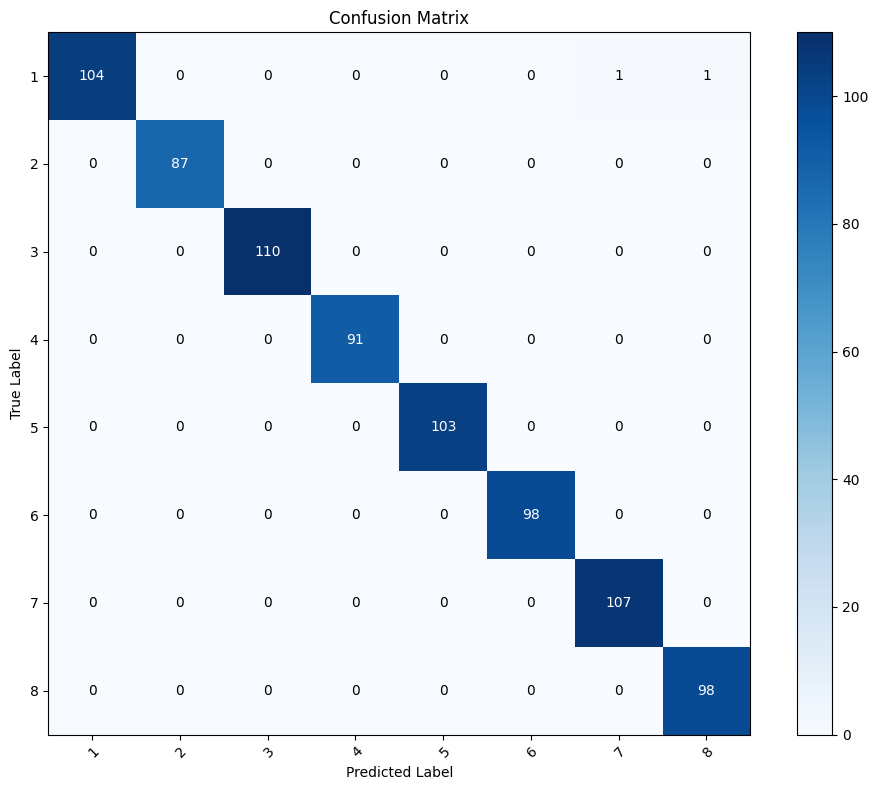

In [38]:
plot_confusion_matrix(y_val, y_val_pred_network_b)

### Perform inference on the test set and save predictions

In [39]:
y_test_pred_network_b = loaded_network_b.forward(X_test)
save_predictions(y_test_pred_network_b, NETWORK_B_PREDICTIONS)

Predictions saved to predictions_for_test_leakyrelu.csv
Total samples: 701
